In [ ]:
#|hide
#| eval: false
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

# Collaborative filtering tutorial

> Using the fastai library for collaborative filtering.

In [ ]:
from fastai.tabular.all import *
from fastai.collab import *

This tutorial highlights on how to quickly build a `Learner` and train a model on collaborative filtering tasks.

## Training a model

For this tutorial, we will use the [Movielens 100k data dataset](https://grouplens.org/datasets/movielens/100k/). We can download it easily and decompress it with the following function:

In [ ]:
path = untar_data(URLs.ML_100k)

The main table is in `u.data`. Since it's not a proper csv, we have to specify a few things while opening it: the tab delimiter, the columns we want to keep and their names.

In [ ]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None,
                      usecols=(0,1,2), names=['user','movie','rating'])
ratings.head()

,user,movie,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


Movie ids are not ideal to look at things, so we load the corresponding movie id to the title that is in the table `u.item`:

In [ ]:
movies = pd.read_csv(path/'u.item',  delimiter='|', encoding='latin-1',
                     usecols=(0,1), names=('movie','title'), header=None)
movies.head()

,movie,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


Next we merge it to our ratings table:

In [ ]:
ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,title
0,196,242,3,Kolya (1996)
1,63,242,3,Kolya (1996)
2,226,242,5,Kolya (1996)
3,154,242,3,Kolya (1996)
4,306,242,5,Kolya (1996)


We can then build a `DataLoaders` object from this table. By default, it takes the first column for user, the second column for the item (here our movies) and the third column for the ratings. We need to change the value of `item_name` in our case, to use the titles instead of the ids:

In [ ]:
dls = CollabDataLoaders.from_df(ratings, item_name='title', bs=64)

In all applications, when the data has been assembled in a `DataLoaders`, you can have a look at it with the `show_batch` method:

In [ ]:
dls.show_batch()

,user,title,rating
0,181,"Substitute, The (1996)",1
1,189,Ulee's Gold (1997),3
2,6,L.A. Confidential (1997),4
3,849,"Net, The (1995)",5
4,435,Blade Runner (1982),4
5,718,My Best Friend's Wedding (1997),4
6,279,I Love Trouble (1994),2
7,561,"Clockwork Orange, A (1971)",4
8,87,"Fish Called Wanda, A (1988)",5
9,774,"Crow, The (1994)",3


fastai can create and train a collaborative filtering model by using `collab_learner`:

In [ ]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))

It uses a simple dot product model with 50 latent factors. To train it using the 1cycle policy, we just run this command:

In [ ]:
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.967653,0.942309,00:10
1,0.843426,0.869254,00:10
2,0.733788,0.823143,00:10
3,0.593507,0.811050,00:10
4,0.480942,0.811475,00:10


Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on RMSE of 0.91 (scroll down to the 100k dataset), which corresponds to an MSE of `0.91**2 = 0.83`. So in less than a minute, we got pretty good results!

## Interpretation

Let's analyze the results of our previous model. We will keep the 1000 most rated movies for this:

In [ ]:
g = ratings.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)',
       'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)',
       'Air Force One (1997)', 'Independence Day (ID4) (1996)'],
      dtype=object)

### Movie bias

Our model has learned one bias per movie, a unique number independent of users that can be interpreted as the intrinsic "value" of the movie. We can grab the bias of each movie in our `top_movies` list with the following command:

In [ ]:
movie_bias = learn.model.bias(top_movies, is_item=True)
movie_bias.shape

torch.Size([1000])

Let's compare those biases with the average ratings:

In [ ]:
mean_ratings = ratings.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

Now let's have a look at the movies with the worst bias:

In [ ]:
item0 = lambda o:o[0]
sorted(movie_ratings, key=item0)[:15]

[(tensor(-0.3489),
  'Children of the Corn: The Gathering (1996)',
  1.3157894736842106),
 (tensor(-0.3407), 'Leave It to Beaver (1997)', 1.8409090909090908),
 (tensor(-0.3304), 'Cable Guy, The (1996)', 2.339622641509434),
 (tensor(-0.2763),
  'Lawnmower Man 2: Beyond Cyberspace (1996)',
  1.7142857142857142),
 (tensor(-0.2607), "McHale's Navy (1997)", 2.1884057971014492),
 (tensor(-0.2572), 'Grease 2 (1982)', 2.0),
 (tensor(-0.2482), 'Kansas City (1996)', 2.260869565217391),
 (tensor(-0.2479), 'Crow: City of Angels, The (1996)', 1.9487179487179487),
 (tensor(-0.2388), 'Free Willy 3: The Rescue (1997)', 1.7407407407407407),
 (tensor(-0.2338), 'Keys to Tulsa (1997)', 2.24),
 (tensor(-0.2305), 'Beautician and the Beast, The (1997)', 2.313953488372093),
 (tensor(-0.2205), 'Escape from L.A. (1996)', 2.4615384615384617),
 (tensor(-0.2192), 'Beverly Hills Ninja (1997)', 2.3125),
 (tensor(-0.2179), 'Mortal Kombat: Annihilation (1997)', 1.9534883720930232),
 (tensor(-0.2150), 'Thinner (1996)',

Or the ones with the best bias:

In [ ]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(tensor(0.6052), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.5778), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.5565), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.5460), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.5264), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.5125), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.4862), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.4851), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.4671), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.4668), 'Apt Pupil (1998)', 4.1),
 (tensor(0.4614), "One Flew Over the Cuckoo's Nest (1975)", 4.291666666666667),
 (tensor(0.4606), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.4572), 'Contact (1997)', 3.8035363457760316),
 (tensor(0.4529), 'Close Shave, A (1995)', 4.491071428571429),
 (tensor(0.4410), 'Wrong Trousers, The (1993)', 4.466101694915254)]

There is certainly a strong correlation!

### Movie weights

Now let's try to analyze the latent factors our model has learned. We can grab the weights for each movie in `top_movies` the same way as we did for the bias before.

In [ ]:
movie_w = learn.model.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 50])

Let's try a PCA to reduce the dimensions and see if we can see what the model learned:

In [ ]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [ ]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

Here are the highest score on the first dimension:

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1481), 'Casablanca (1942)'),
 (tensor(1.0816), 'Chinatown (1974)'),
 (tensor(1.0486), 'Lawrence of Arabia (1962)'),
 (tensor(1.0459), 'Wrong Trousers, The (1993)'),
 (tensor(1.0282), 'Secrets & Lies (1996)'),
 (tensor(1.0245), '12 Angry Men (1957)'),
 (tensor(1.0095), 'Some Folks Call It a Sling Blade (1993)'),
 (tensor(0.9874), 'Close Shave, A (1995)'),
 (tensor(0.9800), 'Wallace & Gromit: The Best of Aardman Animation (1996)'),
 (tensor(0.9791), 'Citizen Kane (1941)')]

And the worst:

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.2520), 'Home Alone 3 (1997)'),
 (tensor(-1.2118), 'Jungle2Jungle (1997)'),
 (tensor(-1.1282), 'Stupids, The (1996)'),
 (tensor(-1.1229), 'Free Willy 3: The Rescue (1997)'),
 (tensor(-1.1161), 'Leave It to Beaver (1997)'),
 (tensor(-1.0821), 'Children of the Corn: The Gathering (1996)'),
 (tensor(-1.0703), "McHale's Navy (1997)"),
 (tensor(-1.0695), 'Bio-Dome (1996)'),
 (tensor(-1.0652), 'Batman & Robin (1997)'),
 (tensor(-1.0627), 'Cowboy Way, The (1994)')]

Same thing for our second dimension:

In [ ]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]

In [ ]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1196), 'Braveheart (1995)'),
 (tensor(1.0969), 'Raiders of the Lost Ark (1981)'),
 (tensor(1.0365), 'Independence Day (ID4) (1996)'),
 (tensor(0.9631), 'Titanic (1997)'),
 (tensor(0.9450), 'American President, The (1995)'),
 (tensor(0.8893), 'Forrest Gump (1994)'),
 (tensor(0.8757), 'Hunt for Red October, The (1990)'),
 (tensor(0.8638), 'Pretty Woman (1990)'),
 (tensor(0.8019), 'Miracle on 34th Street (1994)'),
 (tensor(0.7956), 'True Lies (1994)')]

In [ ]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-0.9231), 'Ready to Wear (Pret-A-Porter) (1994)'),
 (tensor(-0.8948), 'Dead Man (1995)'),
 (tensor(-0.8816), 'Clockwork Orange, A (1971)'),
 (tensor(-0.8697), 'Three Colors: Blue (1993)'),
 (tensor(-0.8425), 'Beavis and Butt-head Do America (1996)'),
 (tensor(-0.8047), 'Cable Guy, The (1996)'),
 (tensor(-0.7832), 'Nosferatu (Nosferatu, eine Symphonie des Grauens) (1922)'),
 (tensor(-0.7662), 'Exotica (1994)'),
 (tensor(-0.7546), 'Spice World (1997)'),
 (tensor(-0.7491), 'Heavenly Creatures (1994)')]

And we can even plot the movies according to their scores on those dimensions:

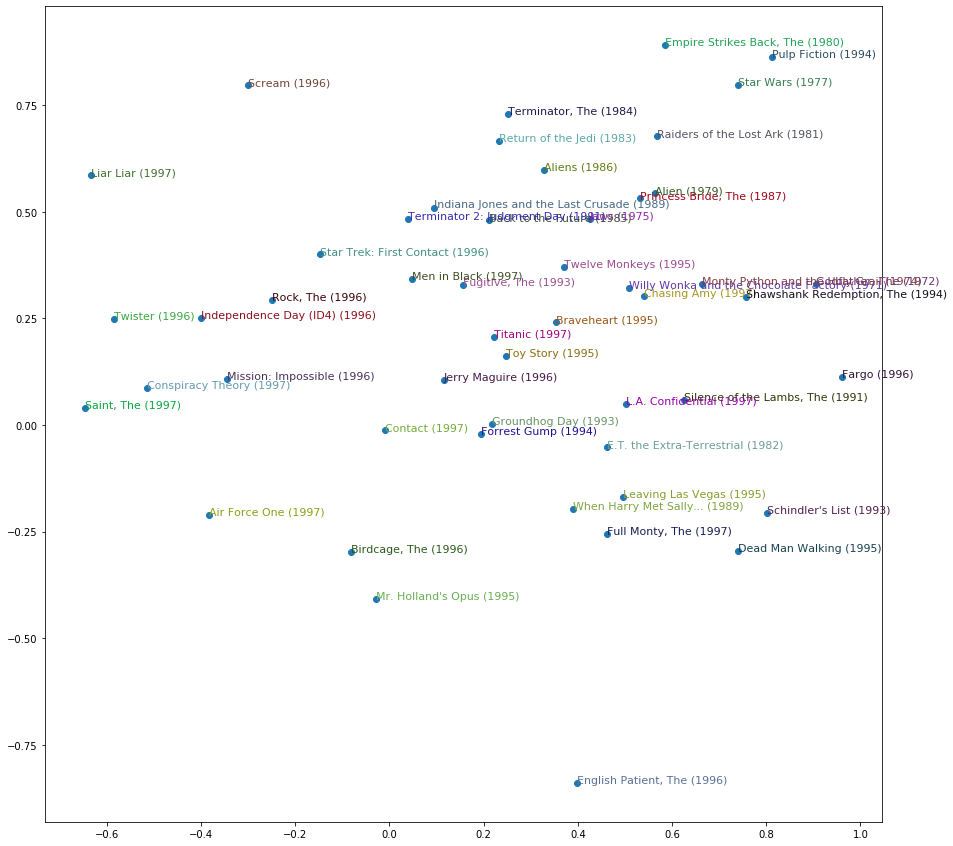

In [ ]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()